# Model Comparison

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from surprise import Dataset, Reader, SVD, KNNBasic, NMF
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise import accuracy

In [2]:
# Define the data files
interaction_data_file = 'Data/interaction_data_prepared.csv'

# Import data file into dataframe
interaction_dataframe = pd.read_csv(interaction_data_file)

In [3]:
# Prepare data for Surprise using the weighted interactions
reader = Reader(rating_scale=(interaction_dataframe['SCORE'].min(), interaction_dataframe['SCORE'].max()))
data = Dataset.load_from_df(interaction_dataframe[['USER_ID', 'BRAND_ID', 'SCORE']], reader)

# Train-test split
trainset, testset = train_test_split(data, test_size=0.1)

In [4]:
# Define parameter grids for each algorithm
param_grid_svd = {
    'n_factors': [50, 100, 150, 200],
    'n_epochs': [20, 30, 40],
    'lr_all': [0.005, 0.01],
    'reg_all': [0.02, 0.1]
}

param_grid_knn = {
    'k': [10, 20, 30, 40],
    'sim_options': {'name': ['msd', 'cosine'], 'user_based': [False, True]}
}

param_grid_nmf = {
    'n_factors': [15, 30, 50, 100],
    'n_epochs': [20, 50],
    'reg_pu': [0.06, 0.1],
    'reg_qi': [0.06, 0.1]
}

# Perform grid search for each algorithm
gs_svd = GridSearchCV(SVD, param_grid_svd, measures=['rmse'], cv=3)
gs_knn = GridSearchCV(KNNBasic, param_grid_knn, measures=['rmse'], cv=3)
gs_nmf = GridSearchCV(NMF, param_grid_nmf, measures=['rmse'], cv=3)

# Fit grid search models
gs_svd.fit(data)
gs_knn.fit(data)
gs_nmf.fit(data)

# Extract best models and their parameters
best_svd = gs_svd.best_estimator['rmse']
best_knn = gs_knn.best_estimator['rmse']
best_nmf = gs_nmf.best_estimator['rmse']

results_svd = cross_validate(best_svd, data, measures=['RMSE', 'MAE'], cv=5, return_train_measures=True)
results_knn = cross_validate(best_knn, data, measures=['RMSE', 'MAE'], cv=5, return_train_measures=True)
results_nmf = cross_validate(best_nmf, data, measures=['RMSE', 'MAE'], cv=5, return_train_measures=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

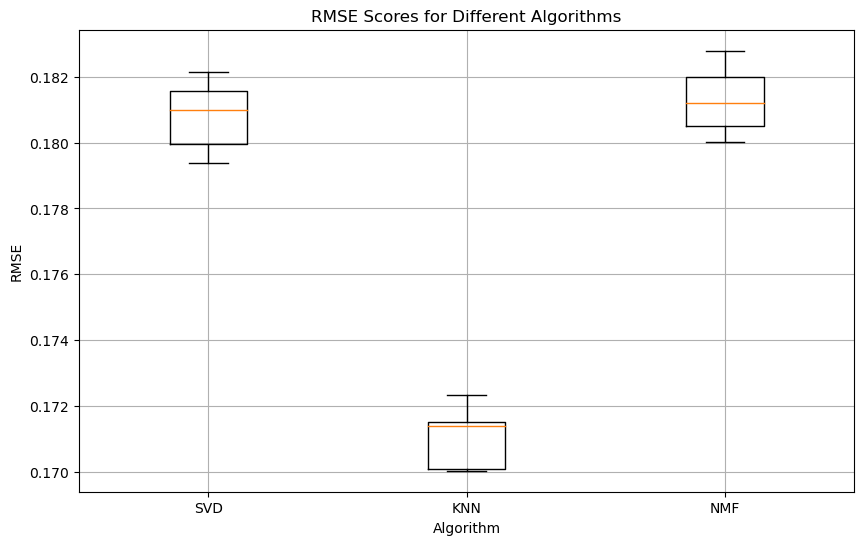

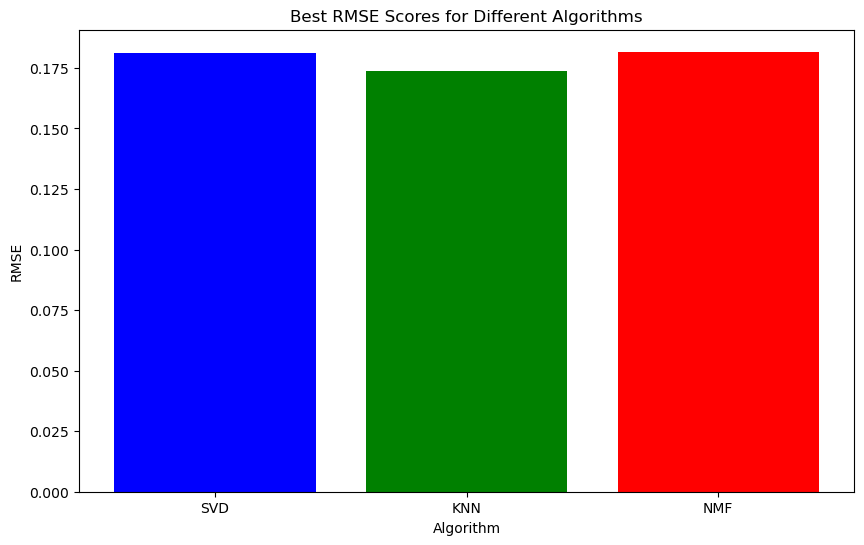

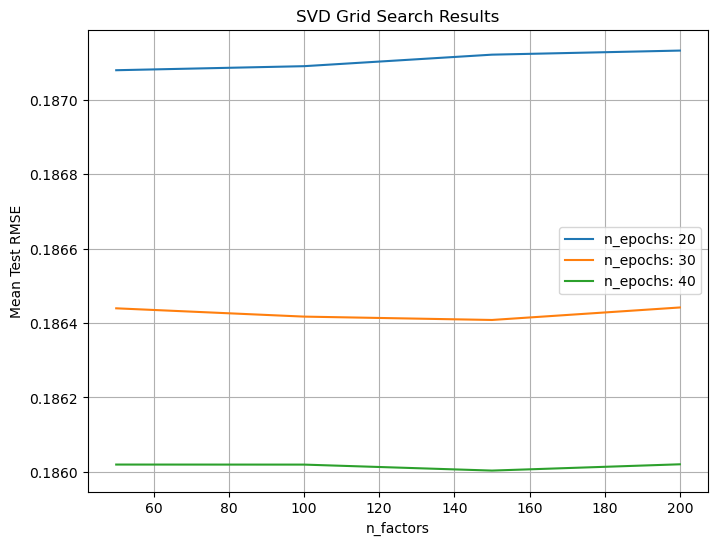

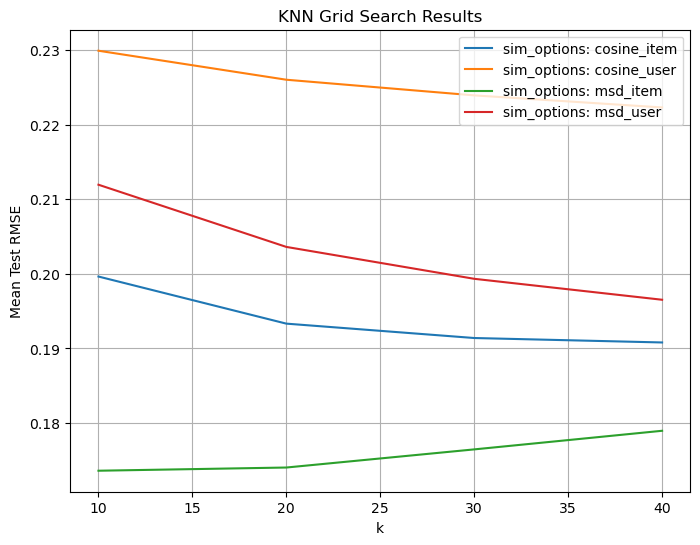

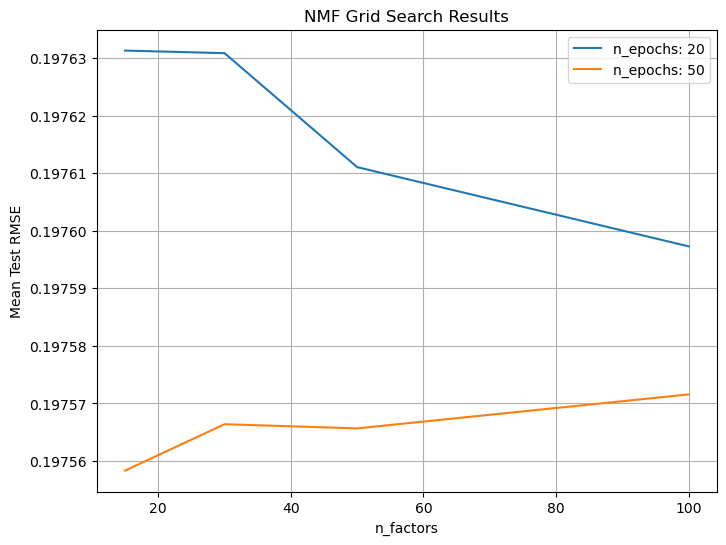

In [5]:
# Collecting results for visual representation
results = {
    'SVD': results_svd['test_rmse'],
    'KNN': results_knn['test_rmse'],
    'NMF': results_nmf['test_rmse']
}

# Convert results to a DataFrame for easier plotting
results_df = pd.DataFrame(results)

# Plot RMSE scores for each algorithm
plt.figure(figsize=(10, 6))
plt.boxplot([results_svd['test_rmse'], results_knn['test_rmse'], results_nmf['test_rmse']],
            labels=['SVD', 'KNN', 'NMF'])
plt.title('RMSE Scores for Different Algorithms')
plt.ylabel('RMSE')
plt.xlabel('Algorithm')
plt.grid(True)
plt.show()

# Plot the best RMSE scores for each algorithm
best_scores = [gs_svd.best_score['rmse'], gs_knn.best_score['rmse'], gs_nmf.best_score['rmse']]
algorithms = ['SVD', 'KNN', 'NMF']

plt.figure(figsize=(10, 6))
plt.bar(algorithms, best_scores, color=['blue', 'green', 'red'])
plt.title('Best RMSE Scores for Different Algorithms')
plt.ylabel('RMSE')
plt.xlabel('Algorithm')
plt.show()

# Visualize the parameter search results
def plot_grid_search(cv_results, param_grid, param_name1, param_name2, title):
    scores_mean = np.array(cv_results['mean_test_rmse'])
    scores_params = cv_results['params']

    # Get unique values for the parameters
    param1_values = sorted({params[param_name1] for params in scores_params})
    param2_values = sorted({params[param_name2] for params in scores_params})
    
    scores_mean_matrix = np.zeros((len(param2_values), len(param1_values)))

    for i, val2 in enumerate(param2_values):
        for j, val1 in enumerate(param1_values):
            for idx, params in enumerate(scores_params):
                if params[param_name1] == val1 and params[param_name2] == val2:
                    scores_mean_matrix[i, j] = scores_mean[idx]

    plt.figure(figsize=(8, 6))
    for idx, val in enumerate(param2_values):
        plt.plot(param1_values, scores_mean_matrix[idx], label=f'{param_name2}: {val}')
    
    plt.title(title)
    plt.xlabel(param_name1)
    plt.ylabel('Mean Test RMSE')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Plot grid search results for SVD
plot_grid_search(gs_svd.cv_results, param_grid_svd, 'n_factors', 'n_epochs', 'SVD Grid Search Results')

# Plot grid search results for KNN
def plot_knn_grid_search(cv_results, param_grid, param_name1, param_name2, title):
    scores_mean = np.array(cv_results['mean_test_rmse'])
    scores_params = cv_results['params']

    param1_values = sorted({params[param_name1] for params in scores_params})
    param2_values = sorted({params[param_name2]['name'] + ('_user' if params[param_name2]['user_based'] else '_item') for params in scores_params})
    
    scores_mean_matrix = np.zeros((len(param2_values), len(param1_values)))

    for i, val2 in enumerate(param2_values):
        for j, val1 in enumerate(param1_values):
            for idx, params in enumerate(scores_params):
                val2_combined = params[param_name2]['name'] + ('_user' if params[param_name2]['user_based'] else '_item')
                if params[param_name1] == val1 and val2_combined == val2:
                    scores_mean_matrix[i, j] = scores_mean[idx]

    plt.figure(figsize=(8, 6))
    for idx, val in enumerate(param2_values):
        plt.plot(param1_values, scores_mean_matrix[idx], label=f'{param_name2}: {val}')
    
    plt.title(title)
    plt.xlabel(param_name1)
    plt.ylabel('Mean Test RMSE')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

plot_knn_grid_search(gs_knn.cv_results, param_grid_knn, 'k', 'sim_options', 'KNN Grid Search Results')

# Plot grid search results for NMF
plot_grid_search(gs_nmf.cv_results, param_grid_nmf, 'n_factors', 'n_epochs', 'NMF Grid Search Results')